# Analiza raspodele podataka u Pythonu

Kao što je već pomenuto, svi ovi podaci jednog skupa podataka su organizovani u tabelarnoj strukturi. Jedna vrsta ove strukture je skup podataka o raznim opažajima (ulazni podatak) i jedan ili više podataka koji se smatraju analizom podataka o opažajima (izlazni podatak). Jedna kolona ove strukture skladišti sve podatke jedne veličine - svi ovi podaci su iste prirode, pa i istog tipa.

Za demonstraciju procesa analize podataka u Pythonu koristiće se skup podataka o preživelim putnicima broda Titanik. Ovaj skup sadrži podatke o putnicima broda, odnosno:

- ID putnika
- Putnik je preživeo ili ne
- Klasa u kojoj je putnik smešten
- Pol putnika
- Starost putnika
- Broj putnika u srodstvu u istom kolenu, odnosno u bračnom odnosu (braća, sestre, supružnici)
- Broj putnika u srodstvu u prethodnom ili sledećem kolenu (roditelji, deca)
- Broj kupljene karte
- Cena kupljene karte
- Oznaka kabine
- Oznaka luke u kojoj je putnik ukrcan

In [3]:
import pandas as pd
df=pd.read_csv('kurs_titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Problem koji je potrebno rešiti je predviđanje verovatnoće preživljavanja ili stradanja putnika, na osnovu poznatih podataka. Pošto izlazna veličina sadrži samo dve moguće vrednosti, ovo je problem binarne klasifikacije.

Analiza podataka se generalno svodi na tri grupe razmatranja. Svaka od ovih grupa razmatranja može da rezultuje zaključcima koji mogu da ukažu na primenu odgovarajućih metoda pripreme podataka kojima se može poboljšati tačnost modela ili performanse učenja.

1. Analiza tipova podataka
    Ukazuje na moguće eksplicitno definisanje tipova pojedinačnih veličina
2. Statistička analiza individualnih veličina
    Ukazuje na moguće primene metode skaliranja podataka ili logaritamske transformacije
3. Analiza korelacije
    Ukazuje na izbor veličina koje imaju uticaj na vrednost izlaznih veličina, odnosno tačnost predviđanja
4. Izbor/selekcija veličina
    Sami algoritmi se koriste da procene relevantnost veličina za tačnost predviđanja.

## Vrste podataka u jednom skupu i opšte karakteristike skupa

Kao što se gore i vidi, u jednom skupu podataka mogu da postoje veličine različitih tipova. Podatak može da bude ceo broj, realan broj, tekst, datum, kategorija (ukoliko postoji poznat konačan broj mogućih vrednosti neke veličine, koje mogu da budu različitih tipova), nedostajuća vrednost (NaN). Prilikom učitavanja skupa podataka, Python automatski procenjuje tipove podataka različitih veličina tog skupa.

Prvi uvid u podatke koji su učitani u DataFrame strukturu se može dobiti analizom rezultata izvršenja funkcije info() tog DataFrame-a. Tim uvidom se utvrđuju dva elementa, važna za dalje tumačenje i kasnije, pripremu podataka: tipovi podataka u skupu i prisustvo nedostajućih vrednosti.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Uočene karakteristike skupa i pojedinačnih podataka:

- U skupu postoji 891 vrsta
- Neki podaci nedostaju. Podatak o godinama starosti postoji samo za 714 putnika. Postoji veoma malo podataka (204) o broju kabine za pojedinačne putnike.
- Veličine: cena karte i godine starosti su realni brojevi (float). Ostale veličine sadrže cele brojeve (int) ili tekst (object).

Očigledno je da neke veličine nisu odgovarajućeg tipa. Na primer, veličina Survived može da sadrži samo podatke 0 ili 1, što znači da je ona tipa kategorije, kao i veličina Sex, koja ukazuje na pol putnika.

Postoji sumnja da je to slučaj i za veličinu Embarked. Ova sumnja se može ispitati navođenje svih vrednosti koje se pojavljuju u koloni sa podacima ove veličine, pri čemu možemo uočiti i broj pojavljivanja svake od tih vrednosti, odnosno njihovu raspodelu.

In [3]:
df.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

Dole je navedena analiza pojavljivanja različitih vrednosti veličine Pclass.

In [4]:
df.groupby('Pclass').size()

Pclass
1    216
2    184
3    491
dtype: int64

S obzirom na to da postoje samo tri moguće vrednosti, moglo bi se reći da je ovo nominalna veličina. Ipak, to nije slučaj, iako se i dalje radi o veličini kategorije. Naime, pored nominalnih veličina tipa kategorije, postoje i ordinalne veličine. Ordinalne veličine takođe mogu da imaju samo konačan broj vrednosti, ali redosled tih vrednosti ima značaj, što nije slučaj sa nominalnim. Zbog toga, ordinalne veličine se uobičajeno u modelima predstavljaju tipom celobrojnih vrednosti.

### Prvi koraci u pripremi podataka

Iako veličina Age sadrži cele brojeve, ona je prepoznata kao float (realni brojevi). Razlog za to je prisustvo nedostajućih vrednosti. Veličina tipa int ne može da sadrži nedostajuće vrednosti.

Iako promena tipova ne predstavlja sastavni deo analize podataka, već njihove pripreme, radi konzistentnosti analize tipovi će biti promenjeni u odgovarajuće.

In [5]:
df['Survived']=df['Survived'].astype('category')
df['Sex']=df['Sex'].astype('category')
df['Embarked']=df['Embarked'].astype('category')

Iako uklanjanje kolona zbog nerelevantnosti veličina ne predstavlja sastavni deo analize podataka, već njihove pripreme, radi konzistentnosti analize biće obrisana veličina PassengerId.

In [6]:
df=df.drop('PassengerId',1)

## Analiza raspodele pojedinačnih veličina 

### Raspodela vrednosti izlazne veličine i referentna tačnost

Prilikom analize podataka, veoma je važno proceniti raspodelu vrednosti izlazne veličine.

In [7]:
df.groupby('Survived').size()

Survived
0    549
1    342
dtype: int64

Iz rezultata gore se vidi da u skupu podataka postoji veći broj onih koji nisu preživeli nesreću. 

Intuitivno, za problem binarne klasifikacije se često pretpostavlja da je verovatnoća slučajnog pogađanja 50%. Da bi procenili minimalnu verovatnoću predviđanja klasifikacije, potrebno je prvo da utvrdimo raspodelu vrednosti izlazne veličine. Ukoliko je ona potpuno ravnomerna (na primer, 50% putnika u skupu podataka je stradalo, a 50% - preživelo), verovatnoća predviđanja bi bila jednaka verovatnoći slučajnog pogađanja.

Pošto raspodela u ovom slučaju nije ravnomerna, umesto slučajnog pogađanja, uspešnije pogađanje bi bilo da uvek pretpostavimo da putnik nije preživeo. U tom slučaju verovatnoća da je naše pogađanje tačno bi bila:

In [8]:
stradalih=df.groupby('Survived').size()[0]
prezivelih=df.groupby('Survived').size()[1]
print(stradalih/(stradalih+prezivelih))

0.6161616161616161


Ovu vrednost nazivamo referentnom tačnošću modela. Tokom postupka izrade modela mašinskog učenja, biće ispitane razne kombinacije algoritama i njihovih podešavanja, grupa korišćenih veličina itd. Sve procene tačnosti veće od 0.61 znače da je novi model bolji od referentnog.

### Osnovni statistički parametri pojedinačnih veličina - raspodela veličina

Korišćenjem funkcije describe() DataFrame strukture, moguće je steći uvid u osnovne statističke atribute njegovih pojedinačnih veličina. Podrazumevano se prikazuju atributi veličina tipa int ili float (ukoliko postoje, nedostajuće vrednosti se ne uzimaju u obzir). Osnovni statistički atributi su:

- Broj podataka
- Srednja vrednost - definiše vrednost koncentracije grupe vrednosti
- Standardna devijacija - definiše varijabilnost ili disperziju grupe vrednosti. Manja standardna devijacija znači veću koncentraciju, a veća - raspršenost vrednosti u skupu podataka
- Minimalna vrednost
- Prva kvartila (25%, Q1) - srednja vrednost svih podataka između medijane i minimalne vrednosti
- Druga kvartila (50%, Q2) - medijana
- Treća kvartila (75%, Q3) - srednja vrednost svih podataka između medijane i maksimalne vrednosti

In [9]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


Za prikaz svih parametara i to svih veličina, koristi se sledeći oblik funkcije describe.

In [10]:
df.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.0,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,2.0,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,0.0,NaN,"Thayer, Mr. John Borland",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,549.0,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,NaN,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,NaN,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,NaN,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,NaN,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,NaN,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,NaN,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Moguće je instrukciju describe koristiti i za prikaz osnovnih statističkih atributa pojedinačnih veličina.

In [11]:
df.Pclass.describe()

count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64

Konačno, moguće je prikazati i pojedinačne statističke atribute pojedinačnih veličina. Ovo je posebno značajno za veličine tipa kategorija. Naime, pored mogućih vrednosti i raspodele, njihov najznačajniji atribut je medijana - vrednost sa najvećim brojem pojavljivanja u skupu podataka (za nominalne veličine, nijedan od gore navedenih atributa nije relevantan).

In [12]:
import numpy as np
print(np.median(df['Pclass']))

3.0


### Opsezi i raspodele vrednosti pojedinačnih veličina

Važna moguća zapažanja na osnovu uvida u vrednosti statističkih atributa su opsezi i raspodele vrednosti pojedinačnih veličina. 

Prvo, jedan od aspekata pripreme podataka su i postupci normalizacije ili standardizacije. Oni se primenjuju radi svođenja vrednosti jedne veličine u interval (0,1) ili (-1,1). Na ovaj način, značajno se može unaprediti brzina rada nekih od algoritama (postupak učenja može da traje dugo ukoliko ima mnogo podataka), dok se kod drugih dovođenje svih veličina u isti opseg vezuje i za znatno poboljšanu tačnost (npr. kod algoritama koji se zasnivaju na sličnosti - kNN). Odluka o tome koje veličine treba normalizovati ili standardizovati se donosi u ovoj fazi - prilikom analize statističkih atributa.

Drugo, ne vezano za interval u kojem se vrednosti neke veličine menjaju, vrsta raspodele u njemu ima potencijalno veliki uticaj na tačnost nekih algoritama. Na primer, parametarski algoritmi su izuzetno uspešni sa normalnom raspodelom. Normalna ili Gausova raspodela ima oblik zvona i česta je u prirodi - godine starosti, prihod, težina, visina. Upravo zbog njenog čestog pojavljivanja, smatra se dobrom aproksimacijom onda kada nam ona nije poznata (imamo samo uzorak podataka o nekoj pojavi u prirodi).

Dole je prikazan primer normalne distribucije. Kod za prikaz ovog dijagrama nije deo vežbe, već se koristi samo za ilustraciju normalne raspodele.

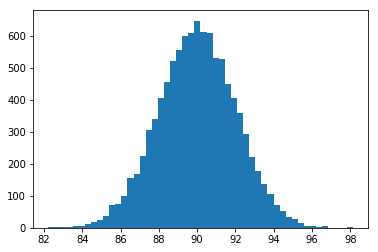

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
values= np.random.normal(90,2, 10000)
plt.hist(values,50)
plt.show()

Druga raspodela koja se često pojavljuje u prirodi je eksponencijalna (ili eksponencijalna kumulativna) distribucija. Iako ona nije poželjna kod parametarskih algoritama, ona se može transformisati u normalnu korišćenjem logaritamske transformacije podataka te veličine. Odnosno, adekvatnom pripremom podataka se može dobiti nova veličina čija će raspodela biti normalna.

Dole je prikazan primer eksponencijalne raspodele. Kod za prikaz ovog dijagrama nije deo vežbe, već se koristi samo za ilustraciju eksponencijalne raspodele.

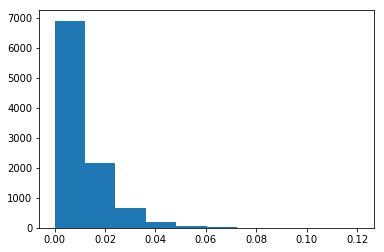

In [14]:
values= np.random.exponential(0.01, 10000)
plt.hist(values)
plt.show()

Analiza raspodele ima smisla samo za veličine numeričkog tipa, odnosno cele i realne brojeve.

Normalna raspodela se može delimično uočiti iz prikaza osnovnih statističkih atributa, jer je potreban (ali ne i dovoljan) uslov za nju jednakost srednje vrednosti i medijane.

- Kod veličine Age, mean=29.7, a median (50%)=28. Zaključujemo da je raspodela godina starosti veoma bliska normalnoj.
- Kod veličine Fare, mean=32.2, a median=14.4. Zaključujemo da raspodela cene karata nije bliska normalnoj. Ipak, moguće je da ova raspodela eksponencijalna.

Još jedan način za nedvosmisleno određivanje bliskosti raspodele vrednosti neke veličine normalnoj je i analiza zakošenosti veličina. Vrednosti zakošenosti bliske nuli ukazuju na normalnu raspodelu. Ukoliko su vrednosti veće od nule, postoji zakošenost ka levoj strani raspodele. Veće vrednosti zakošenosti ukazuju na moguću eksponencijalnu raspodelu podataka.

In [15]:
df.skew()

Survived    0.478523
Pclass     -0.630548
Age         0.389108
SibSp       3.695352
Parch       2.749117
Fare        4.787317
dtype: float64

### Histogrami

Poslednji i najilustrativniji način za određivanje raspodele vrednosti pojedinačnih veličina su histogrami - dijagrami distribucije numeričkih podataka. Histogrami za sve numeričke veličine se prikazuju pozivanjem metode hist() DataFrame objekta.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000230AE27C3C8>,
      dtype=object)

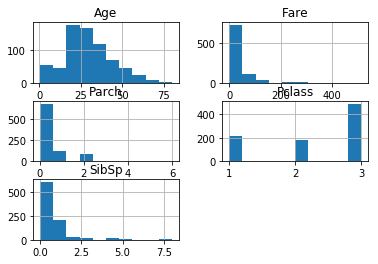

In [16]:
df.hist()

Prikaz histograma za pojedinačne, izabrane veličine u DataFrame objektu se vrši na sledeći način.

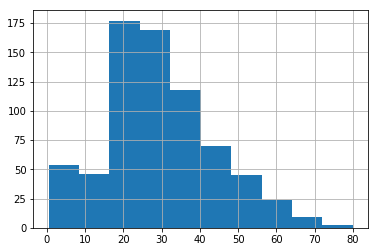

In [17]:
df['Age'].hist()

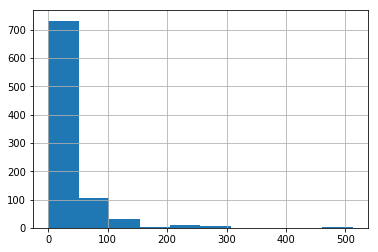

In [18]:
df['Fare'].hist()

Zaključujemo konačno da veličinu Age karakteriše normalna (ili bliska normalnoj) distribucija, a veličinu Fare - eksponencijalna.

### Kutijasti (box and whiskers) dijagrami

Kutijasti dijagrami se koriste za vizuelizaciju varijabilnosti ili raspršenosti podataka u okviru jedne veličine. Svi kutijasti dijagrami numeričkih veličina su prikazani dole. Za prikaz dijagrama se koristi plot funkcija DataFrame strukture koja koristi prethodno uvezeni matplotlib paket. 

Na sličan način, plot komanda se može koristiti i za prikaz drugih vrsta dijagrama, npr. histograma (kind='hist'), dijagrama raspršenosti (kind='scatter') i drugih. Parametar subplots=True ukazuje na prikaz posebnih dijagrama za sve veličine, zbor njihovih različitih opsega.

Objašnjenje dijagrama:
- Donja ivica kutije je Q1 (25%) tačka - prva kvartila.
- Gornja ivica kutije je Q3 (75%) tačka - treća kvartila
- Crta unutar kutije je Q2 (50%, medijana) tačka, odnosno druga kvartila
- Donja tačka pune linije je Q1-1.5*IQR, gornja je Q1+1.5*IQR
    - IQR - Interquartile range 
- Praznim kružićima se obeležavaju autlajeri (outliers) - ekstremne vrednosti

Pclass       AxesSubplot(0.125,0.125;0.133621x0.755)
Age       AxesSubplot(0.285345,0.125;0.133621x0.755)
SibSp      AxesSubplot(0.44569,0.125;0.133621x0.755)
Parch     AxesSubplot(0.606034,0.125;0.133621x0.755)
Fare      AxesSubplot(0.766379,0.125;0.133621x0.755)
dtype: object

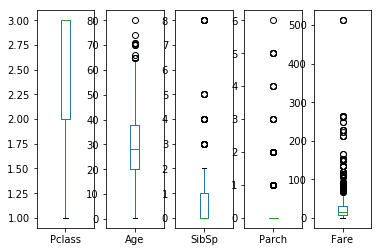

In [19]:
df.plot(kind='box', subplots=True)

Slično histogramima, moguće je prikazati kutijasti dijagram za pojedinačne veličine.

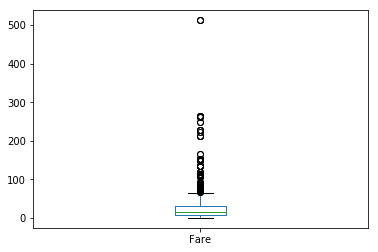

In [20]:
df['Fare'].plot(kind='box')

## Rezime analize tipova i raspodele podataka

Na osnovu svih koraka u statističkoj analizi individualnih veličina, možemo sažeti sve rezultate u sledeće tvrdnje.

- Potrebno je izvršiti određene promene tipova veličina učitanih u DataFrame strukturu
- Potrebno je rešiti problem nedostajućih podataka veličine Age
- Potrebno je ukloniti veličinu Cabin (zbog velikog broja nedostajućih podataka), PassengerId (nema uticaja na verovatnoću preživljavanja) i Ticket (zbog nemogućnosti tumačenja značenja šifara karte)
- Opseg veličina Age i Fare je značajno veći od opsega ostalih veličina.
- Raspodela veličine Age je bliska normalnoj. Raspodele veličina Parch, SibSp i Fare su bliske eksponencijalnoj